# Ames (Iowa) House Price Regression

## Competition Description

"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."

[Link to competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

**Notebook performance/placement: 265/4346**

# Setup

In [1]:
import os
import warnings
from pathlib import Path
import warnings
from tqdm.auto import tqdm
import timeit

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

from scipy.stats import skew, zscore

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import optuna



pd.set_option('display.max_rows', 100)

plt.style.use("seaborn-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

# Load dataset and partial preprocessing

Load data and handling of missing values

In [2]:
ds_path = Path("../input/house-prices-advanced-regression-techniques/")
df_train = pd.read_csv(ds_path / "train.csv", index_col="Id")
X_test = pd.read_csv(ds_path / "test.csv", index_col="Id")

X_train = df_train.drop(["SalePrice"], axis=1)
y_train = pd.DataFrame(df_train["SalePrice"], columns=["SalePrice"])

X_all = pd.concat([X_train, X_test], axis=0)

In [3]:
print("Number of missing values in the target:", y_train.isnull().sum()[0])

Number of missing values in the target: 0


Columns with missing values (34 Affected / 79 Total).



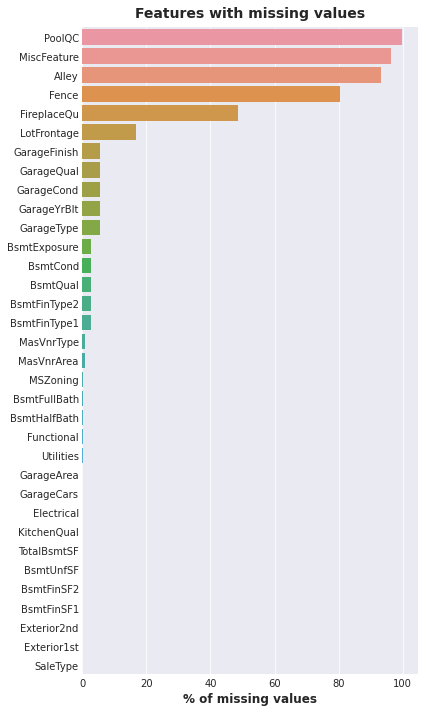

In [4]:
col_missing = X_all.isnull().any()
X_missing = X_all.loc[:, col_missing]

print(f"Columns with missing values ({X_missing.shape[1]} Affected / {X_all.shape[1]} Total).\n")

X_missing_count = X_missing.isnull().sum(axis=0)

perc_missing = (X_missing_count / X_all.shape[0]) * 100
perc_missing = perc_missing.to_frame("percentage_missing").sort_values(by="percentage_missing", ascending=False)

f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=perc_missing, x="percentage_missing", y=perc_missing.index, ax=ax)
ax.set(xlabel="% of missing values", title="Features with missing values");

The majority of features with missing values, expecially the most affected ones, seem to be features which dont have said feature to begin with. In these cases i will convert the missing values to "None" or "0" depending on the feature type (categorical or numerical).

The features with actual missing values are small and can be dropped or imputed. I chosed to impute the values with their mode (Note: Imputation can introduce bias and reduce the variance) because the validation performance was higher.

An exception could be "Lot Frontage" and "GarageYearBuild". In case of the "Lot Frontage" either the properties dont have a frontage or the feature values are missing. Here i will impute the values based on the median lot frontage of the associated neighborhoods. In case of the "GarageYearBuild" i will use the values of the feature "YearBuilt". It is quite common that the garages are build with the house (In the EDA section it turns out, that the garage year build and the house year build positivly correlate).

In [5]:
num_non_existent = [
    "MasVnrArea", "BsmtFullBath", "BsmtHalfBath", "GarageCars",
    "GarageArea", "BsmtUnfSF", "TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2" 
]
X_all[num_non_existent] = X_all[num_non_existent].fillna(0)

cat_missing = [
    "MSZoning", "Functional", "SaleType", "KitchenQual",
    "Exterior2nd", "Exterior1st", "Electrical", "Utilities"
]
imputer = SimpleImputer(strategy="most_frequent")
X_all[cat_missing] = pd.DataFrame(imputer.fit_transform(X_all[cat_missing]), index=X_all.index)

cat_non_existent = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual",
    "GarageCond", "GarageFinish", "GarageType", "BsmtExposure", "BsmtCond",
    "BsmtQual", "BsmtFinType1", "BsmtFinType2", "MasVnrType"
]
X_all[cat_non_existent] = X_all[cat_non_existent].fillna("None")

lf_by_neighborhood = X_train["LotFrontage"].groupby(X_train["Neighborhood"])
for neighborhood, group in lf_by_neighborhood:
        idx = (X_all["Neighborhood"] == neighborhood) & (X_all["LotFrontage"].isnull())
        X_all.loc[idx, "LotFrontage"] = group.median()
X_all["GarageYrBlt"] = X_all["GarageYrBlt"].fillna(X_all["YearBuilt"])

In [6]:
features_nom = [
    "MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1",
    "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
    "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"
]

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode_categorical_features(df):
    # Nominal
    for name in features_nom:
        df[name] = df[name].astype("category")
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df

X_all = encode_categorical_features(X_all)

X_train = X_all.loc[X_train.index].copy()
X_test = X_all.loc[X_test.index].copy()

df_train = pd.concat((X_train, y_train), axis=1)

# EDA

### A first glance

In [7]:
print(f"The training dataset consists out of {X_train.shape[0]} entries with {X_train.shape[1]} features.")
print(f"The test     dataset consists out of {X_test.shape[0]} entries with {X_test.shape[1]} features.")

The training dataset consists out of 1460 entries with 79 features.
The test     dataset consists out of 1459 entries with 79 features.


In [8]:
print(X_all.describe().iloc[:, :15], "\n")
print(X_all.describe().iloc[:, 15:])

       LotFrontage        LotArea    YearBuilt  YearRemodAdd   MasVnrArea  \
count  2919.000000    2919.000000  2919.000000   2919.000000  2919.000000   
mean     69.562350   10168.114080  1971.312778   1984.264474   101.396026   
std      21.703819    7886.996359    30.291442     20.894344   178.854579   
min      21.000000    1300.000000  1872.000000   1950.000000     0.000000   
25%      60.000000    7478.000000  1953.500000   1965.000000     0.000000   
50%      70.000000    9453.000000  1973.000000   1993.000000     0.000000   
75%      80.000000   11570.000000  2001.000000   2004.000000   163.500000   
max     313.000000  215245.000000  2010.000000   2010.000000  1600.000000   

        BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean    441.272011    49.565262   560.579993  1051.417266  1159.581706   
std     455.606014   169.179104   439.590889   441.120498   392.362079   
min       

### The target distribution

The target distribution has a **positive skew**.

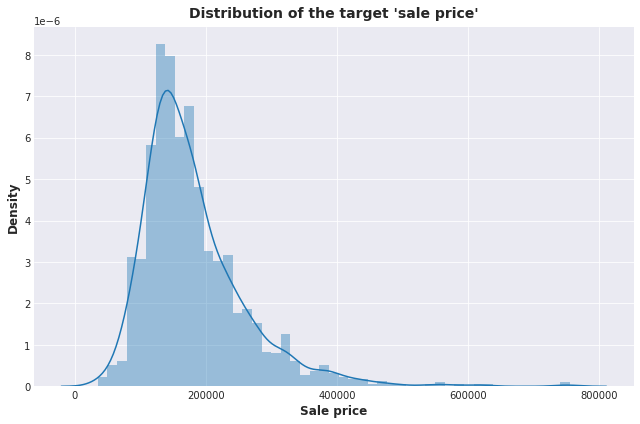

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(y_train)
ax.set(xlabel="Sale price")
plt.title("Distribution of the target 'sale price'");

### Relationships between the target and features

The **Mutual information** and the **correlation** between the feaures and target should give us some information about possible relationships. MI measures the mutual dependence between two random variables, it quantifies the **amount of information** obtained about one random variable by observing the other random variable. It is also not limited to real-valued random variables and linear dependence like the correlation coefficient.

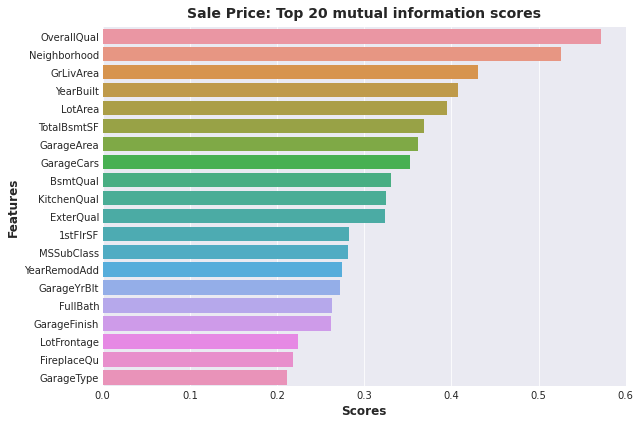

In [10]:
def calc_mi_scores(X, y, topk=-1):
    X = X.copy()
    for col in X.select_dtypes(["category", "object"]):
        X[col], _ = X[col].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(col_type) for col_type in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, index=X.columns, name="MI scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    if topk >= 0:
        return mi_scores.head(topk)
    else:
        return mi_scores

def plot_mi_scores(X, y, topk=-1, title=None, fig_size=(9,6)):
    fig, ax = plt.subplots(figsize=fig_size)
    mi_scores = calc_mi_scores(X,y,topk)
    d = pd.DataFrame({"Features": list(mi_scores.index), "MI_Score": mi_scores.values})
    sns.barplot(y="Features", x="MI_Score", data=d, ax=ax)
    if title == None:
        if topk == -1:
            topk = ""
        ax.set(title=f"Sale Price: Top {topk} mutual information scores", xlabel="Scores")
    else:
        ax.set(title=title, xlabel="Scores")

topk = 20
mi_scores = calc_mi_scores(X_train, y_train, topk)
# print(f"Top {topk} Mutual information scores:\n{mi_scores}\n")
plot_mi_scores(X_train, y_train, topk)

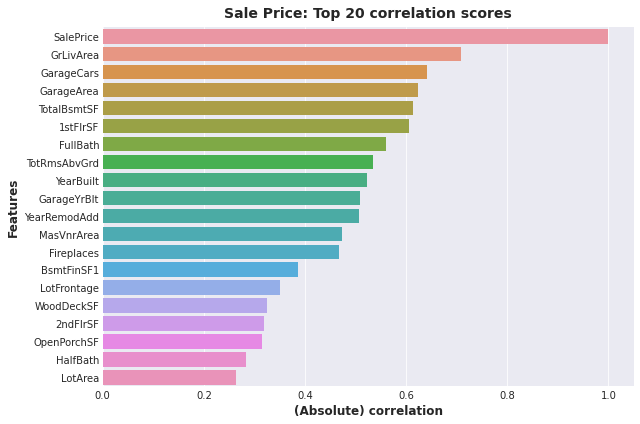

In [11]:
df=pd.concat([X_train, y_train], axis=1)
corr_mat = df.corr()
corr_target = corr_mat["SalePrice"].abs().sort_values(ascending=False)
corr_target = pd.DataFrame({"Features":corr_target.index, "Correlation":corr_target.values})
corr_target = corr_target.head(topk)

# print(corr_target.head(topk))
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=corr_target, x="Correlation", y="Features")
ax.set(xlabel="(Absolute) correlation", title=f"Sale Price: Top {topk} correlation scores");

The mutual information and correlation scores have **some similarities**.

The neighborhood is important, which make sense, since it's often the case that similar valued houses are found in closer proximity to each other. Than e.g. a mansion to a residential complex.

The feature YearBuilt has a high mu score.

The **overall size** of the property (e.g. GrLivArea, LotArea, GarageArea, ...) and the **quality** (e.g. OverallQual, BsmtQual, KitchenQual, ...) also seem to be important.

Lets visualize some of these features to get a better understanding.

### Neighborhood vs Sale Price

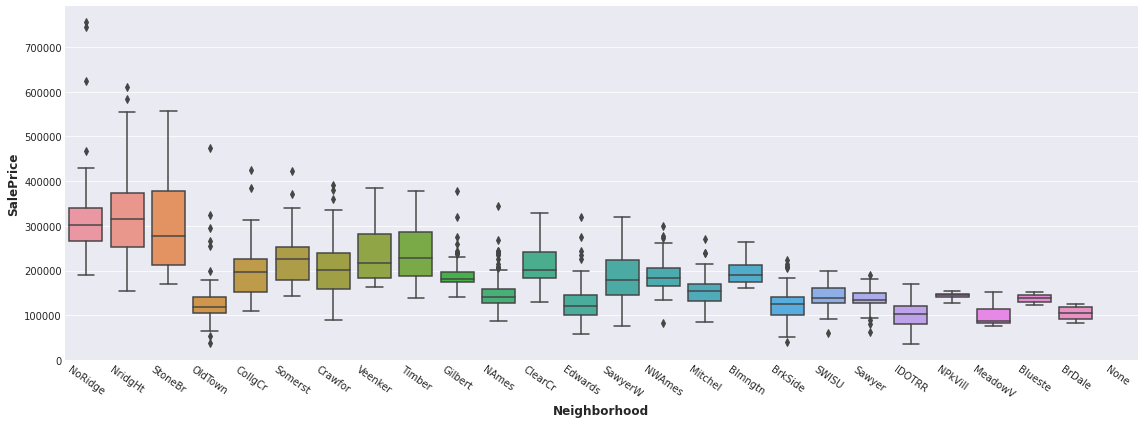

In [12]:
neigh_cost_desc=df_train.groupby(["Neighborhood"])["SalePrice"].max().sort_values(ascending=False).index
plt.figure(figsize=(16,6))
sns.boxplot(x="Neighborhood", y="SalePrice", order=neigh_cost_desc, data=df_train)
tks = plt.xticks(rotation=-35)

We can see a **trend**. The highest median house prices are in the neighborhoods 'NoRidge, NridgHt and StoneBr'. The higher valued neigborhoods seem to have more variability than the cheaper neighborhoods. There are more upper outliers than lower ones, the extrem case being the neighborhood 'NoRidge'.

### Year Built vs Sale Price

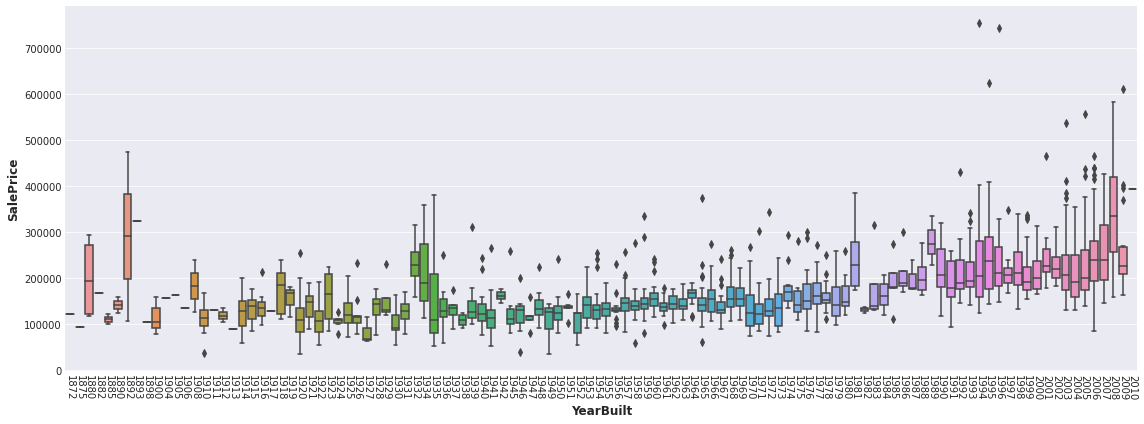

In [13]:
plt.figure(figsize=(16,6))
sns.boxplot(x="YearBuilt", y="SalePrice", data=df_train)
tks=plt.xticks(rotation=-90)

We can see a **positive trend** from 1945-2010. Some of the really old houses are valued relativly high (historic buildings or high maintenance?).

### Quality vs Sale Price

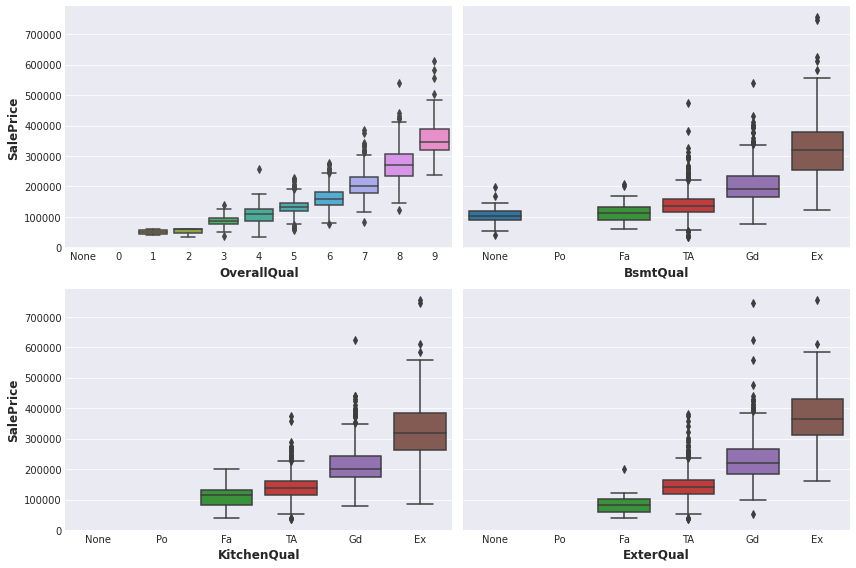

In [14]:
fig, axes = plt.subplots(2,2,figsize=(12,8),sharey=True)
sns.boxplot(x="OverallQual",y="SalePrice",data=df_train, ax=axes[0,0])
sns.boxplot(x="BsmtQual",y="SalePrice",data=df_train,ax=axes[0,1])
axes[0,1].set(ylabel="")
sns.boxplot(x="KitchenQual",y="SalePrice",data=df_train,ax=axes[1,0])
sns.boxplot(x="ExterQual",y="SalePrice",data=df_train,ax=axes[1,1])
axes[1,1].set(ylabel="");

It seems to be that a **higher quality increases the sale price**.

### Ground Living Area vs Price

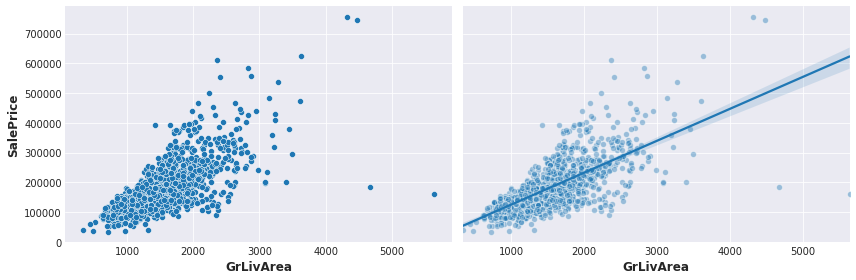

In [15]:
plt.figure(figsize=(12,4))
ax1=plt.subplot(1,2,1)
sns.scatterplot(x="GrLivArea", y="SalePrice", data=df_train)
ax2 = plt.subplot(1,2,2, sharey=ax1)
sns.regplot(x="GrLivArea",y="SalePrice",data=df_train, n_boot=10, scatter_kws={'alpha':0.4, 'edgecolors':'white'})
ax2.set(ylabel="", )
ax2.tick_params(labelleft=False);

Overall a **bigger ground living area increases the sales price**. There seem to be some outliers (GrLivArea > 400 in the price range of 200,000).

### Garage vs Sale Price

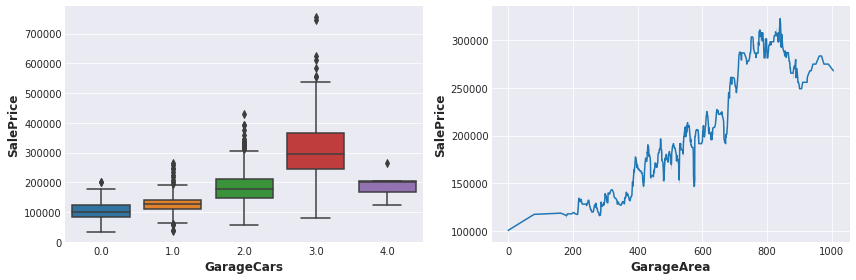

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x="GarageCars",y="SalePrice",data=df_train)

df_temp = df_train[["SalePrice", "GarageArea"]]
df_temp = df_temp.sort_values(by="GarageArea").rolling(window=30, center=True).median()

plt.subplot(1,2,2)
sns.lineplot(x="GarageArea",y="SalePrice",data=df_temp)

del df_temp

Similar to the living area, the garage size increases the sale price, whereby there is a decline from 3->4 Garage Cars and from ~ Garage Areas > 800.

### Heatmap

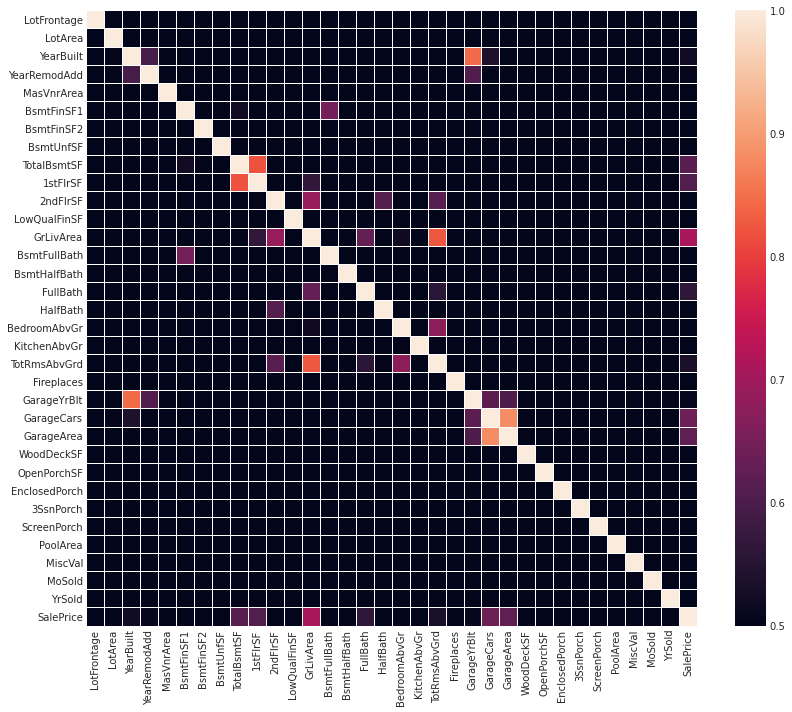

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(), vmin=0.5, linewidth=.9, cmap="rocket");

There is some multicollinearity (-> Hypotheses):
* YearBuild vs GarageYrBlt -> Build at the same time.
* TotalBsmtSF vs FirtFlrSF and GrLivArea vs TotRmsAbvGrd -> The upper floor sizes are often affected by the foundation, the basement floor size.
* Garage Cars vs Garage Area -> A bigger garage area leads to more places available for cars.

The multicollinearity shouldn't negatively influence the performance of the model. It can however make the analysis of the model unreliable.

# Partial Preprocessing 
## Outlier detection/removal

The principal compnents are constructed with some of the most informative numerical features.

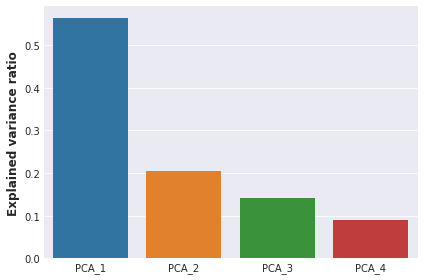


Loadings:
                  PC1       PC2       PC3       PC4
YearBuilt    0.470010 -0.693203  0.032998 -0.545409
TotalBsmtSF  0.507780  0.203939  0.805596  0.227120
GrLivArea    0.465342  0.671656 -0.330099 -0.472620
GarageCars   0.552003 -0.163574 -0.490878  0.653892 



,SalePrice,Neighborhood,SaleCondition,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars
1299,160000,Edwards,Partial,2008,6110.0,5642,2.0
524,184750,Edwards,Partial,2007,3138.0,4676,3.0
1183,745000,NoRidge,Abnorml,1996,2396.0,4476,3.0
692,755000,NoRidge,Normal,1994,2444.0,4316,3.0
441,555000,NridgHt,Normal,2008,3094.0,2402,3.0
...,...,...,...,...,...,...,...
529,86000,Edwards,Normal,1920,528.0,605,0.0
706,55000,IDOTRR,Normal,1930,0.0,1092,0.0
1138,94000,Sawyer,Normal,1875,780.0,1020,0.0
521,106250,OldTown,Normal,1900,0.0,1294,0.0


In [18]:
def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )
    return pca, X_pca, loadings

features = [
    "YearBuilt",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageCars",
]

X = df_train.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)

pca_var_ratio = pca.explained_variance_ratio_
component_names = [f"PCA_{i}" for i in range(1, pca_var_ratio.shape[0]+1)]
pca_expl_var = pd.DataFrame(pca_var_ratio, index=component_names, columns=["Explained variance ratio"])

fig, ax = plt.subplots()
sns.barplot(x=pca_expl_var.index, y="Explained variance ratio", data=pca_expl_var, ax=ax)
plt.show()

print("\nLoadings:")
print(loadings, "\n")

idx = X_pca["PC1"].sort_values(ascending=False).index + 1
pca1_ordered_data = df_train.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]
pca1_ordered_data

PCA_1 explaince, in comparison to the other PCAs, a good deal of the variance, more than twice as much than PCA_2. Looking at the loadings of PCA_1 we can see that all 4 features are similar important. The table displays the entries projected on the PCA_1 in descending order, the upper and lower entries might contain outliers we saw in a previous plot.

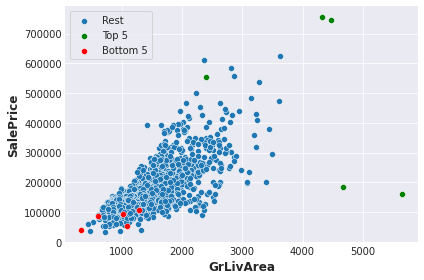

In [19]:
fig, ax = plt.subplots()

k=5
top_k_entr = pca1_ordered_data.head(k)
bottom_k_entr = pca1_ordered_data.tail(k)
rest_entr = pca1_ordered_data.iloc[k:-k, :]

sns.scatterplot(x="GrLivArea", y="SalePrice", data=rest_entr, ax=ax, label="Rest")
sns.scatterplot(x="GrLivArea", y="SalePrice", data=top_k_entr, ax=ax, color="green", label=f"Top {k}")
sns.scatterplot(x="GrLivArea", y="SalePrice", data=bottom_k_entr, ax=ax, color=f"red", label=f"Bottom {k}");
plt.legend(frameon=True);

The two dots on the lower right side are conspicuous.

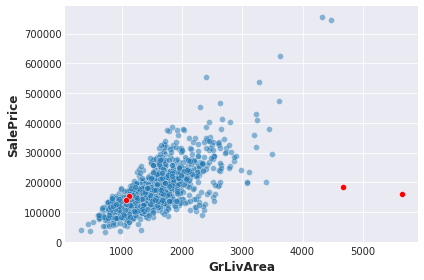

In [20]:
fig, ax = plt.subplots()

d1 = df_train.loc[(df_train["SaleCondition"] != "Partial")]
d2 = df_train.loc[(df_train["SaleCondition"] == "Partial") & (df_train["Neighborhood"] == "Edwards")]

sns.scatterplot(x="GrLivArea", y="SalePrice", data=d1, ax=ax, alpha=0.5)
sns.scatterplot(x="GrLivArea", y="SalePrice", data=d2, ax=ax, color="red");

They are part of a partial sale in the neighborhood edwards. These outliers will be removed.

In [21]:
outlier_idx = X_train[(X_train["GrLivArea"] > 4000) & (X_train["Neighborhood"] == "Edwards")].index
X_train = X_all.loc[X_train.index, :]
X_test = X_all.loc[X_test.index, :]

X_train.drop(outlier_idx, inplace=True)
y_train.drop(outlier_idx, inplace=True)

X_all = pd.concat([X_train, X_test], axis=0)

# Feature engineering

The new features are manly based on the most informative features. In addition the "MoSold" is transformed via the sin and cos function, so that the model can learn the time aspect better.

In [22]:
def drop_uninformative(df, ms_score, treshold=0.1):
    dropped = df.loc[:, ms_score <= treshold]
    df = df.loc[:, ms_score > treshold]
    print("Uninformative features dropped:\n")
    print(list(dropped.columns))
    return df

def mathematical_transforms(X):
    X["HouseSellAge"] = X["YrSold"] - X["YearBuilt"]
    X["TotalSF"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
    X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
    X["TotalBath"] = X["FullBath"] + X["BsmtFullBath"] + 0.5 * (X["BsmtHalfBath"] + X["HalfBath"])
    X["Remodeled"] = (X["YearRemodAdd"] != X["YearBuilt"]) * 1
    X["RecentRemodel"] = (X["YearRemodAdd"] == X["YrSold"]) * 1
    X["YearsSinceRemodel"] = X["YrSold"] - X["YearRemodAdd"]
    
    X["SinMoSold"] = np.sin(2 * np.pi * X["MoSold"] / 12)
    X["CosMoSold"] = np.cos(2 * np.pi * X["MoSold"] / 12)
    X = X.drop("MoSold", axis=1)
    return X

def group_transforms(X):
    X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [23]:
def create_features(X_all, y_train):
    
    X_all = mathematical_transforms(X_all)
    X_all = group_transforms(X_all)
    X_all['YrSold'] = X_all['YrSold'].apply(str).astype("category")

    # Delete uninformative features
#     X_train = X_all.loc[X_train.index,:]
#     ms_score = calc_mi_scores(X_train, y_train)
#     X_all = drop_uninformative(X_all, ms_score)

    return X_all
    

X_all = create_features(X_all, y_train)

#Update contained features
# X_all = pd.concat([X_train, X_test], axis=0)
# cat_cols = X_all.select_dtypes(include="category")

# nominal_cols = features_nom
# nominal_cols = [col for col in nominal_cols if col in cat_cols]

# ordinal_cols = list(ordered_levels.keys())
# ordinal_cols = [col for col in ordinal_cols if col in cat_cols]

# numerical_cols = list(X_all.select_dtypes(exclude="category").columns)

# Standardization

Decrease skewness of features and target by transforming via the log function.

In [24]:
X_temp = X_all[["SinMoSold", "CosMoSold"]]
X_all.drop(["SinMoSold", "CosMoSold"], axis=1, inplace=True)

In [25]:
def transform_skewed(X_all, threshold=0.7):
    skew_value = X_all.skew(numeric_only=True).abs()
    skew_col = skew_value[skew_value > threshold].index
    for col in skew_col:
        X_all[col] = np.log1p(X_all[col])
    return X_all

X_all = transform_skewed(X_all)
X_all = pd.concat([X_all, X_temp], axis=1)

y_train = np.log1p(y_train)

del X_temp

Standardize numerical features with the robust scaler.

In [26]:
numerical_cols = X_all.select_dtypes(np.number).columns
scaler = RobustScaler()
X_all[numerical_cols] = scaler.fit_transform(X_all[numerical_cols])

# Categorical Encoding

The nominal features will be one hot encoded. While the ordinal features will be label encoded.

In [27]:
def label_encoder(df, columns=[]):
    if len(columns) > 0:
        cat_cols = columns
    else:
        cat_cols = df.select_dtypes("category").columns
    for col in cat_cols:
        df[col] = df[col].cat.codes
    return df

def one_hot_encoder(df):
    df = pd.get_dummies(df, drop_first=True)
    return df

# Label encoding for ordinal features
ordinal_cols = list(ordered_levels.keys())
X_all = label_encoder(X_all, ordinal_cols)

# One hot encoding for nominal features
X_all = one_hot_encoder(X_all)

In [28]:
X_train = X_all.loc[X_train.index,:]
X_test = X_all.loc[X_test.index,:]

In [29]:
# Remove outliers from training data
# residuals = y_train - LinearRegression().fit(X_train, y_train).predict(X_train)
# outliers = residuals[np.abs(zscore(residuals)) > 3].index
# X_train = X_train.drop(outliers)
# y_train = y_train.drop(outliers)

# Model

The model is a **meta ensemble**, using the the weighted predictions of the first-level learners **Ridge**, **Lasso**, **Support Vector Regression**, **Light Gradient Boosting Decision Tree**.

The **hyperparameter tuning** is done with the libary **optuna** (which makes use of gaussian processes to make the search process more effecient in comparison to e.g. simple grid search) and **cross validation with 5 folds**.

In [30]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

def objective_Ridge(trial):    
    ridge_params = dict(alpha = trial.suggest_loguniform("alpha",1e-3, 1e3))
    model = Ridge(**ridge_params)
    scores = cross_val_score(model, X_train, y_train, cv=kf) #R2 cv scores
    
    return np.array(scores).mean()


def objective_Lasso(trial):    
    lasso_params = dict(alpha = trial.suggest_loguniform("alpha",1e-3, 1e3))
    model = Lasso(**lasso_params)
    scores = cross_val_score(model, X_train, y_train, cv=kf)
    
    return np.array(scores).mean()


def objective_SVR(trial):
    #svm uses the rbf kernel
    svr_params = dict(
        C = trial.suggest_float("C", 1e-1, 2e0),
        gamma = trial.suggest_float("gamma", 1e-3, 2e-2),
        epsilon = trial.suggest_float("epsilon", 1e-2, 1e-1),
    )
    model = SVR(**svr_params)
    scores = cross_val_score(model, X_train, y_train, cv=kf)
    
    return np.array(scores).mean()


def objective_LightGB(trial):
    
    lgb_params = dict(
        num_leaves = trial.suggest_int("num_leaves", 20, 100),
        max_depth = trial.suggest_int("max_depth", 2, 6),
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-1),
        n_estimators = trial.suggest_int("n_estimators", 1000, 5000),
        min_child_weight = trial.suggest_loguniform("min_child_weight", 1e-4, 1e4),
        subsample = trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.1),
        subsample_freq = trial.suggest_int("subsample_freq", 0, 1),
        colsample_bytree = trial.suggest_discrete_uniform("colsample_bytree", 0.5, 1.0, 0.1),
        reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-3, 1e3),
        reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
        
        boosting_type = "gbdt",
        objective = "regression", #here: regression is an alias for l2 (mean squared error)
        verbose = -1
    )
    
    scores = []
    model = LGBMRegressor(**lgb_params)
    for i, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr, eval_set=[(X_val,y_val)], early_stopping_rounds = 100, verbose= False)

        val_pred = model.predict(X_val)
        scores.append(r2_score(y_val, val_pred))
        
    return np.array(scores).mean()

In [31]:
d_objective = {
    "Ridge" : objective_Ridge,
    "Lasso" : objective_Lasso,
    "SVR" : objective_SVR,
    "LightGB" : objective_LightGB,
}

def bayesian_search(d_objective, n_trials=15):
    d_studies = dict()
    for method, objective in d_objective.items():
        start = timeit.default_timer()
        
        study = optuna.create_study(direction="maximize", study_name=method)
        study.optimize(objective, n_trials=n_trials)
        d_studies[method] = study
        
        stop = timeit.default_timer()
        print(f'Study {method} completed. Runtime: {(stop - start):.6} sec.\n')
    return d_studies

d_studies = bayesian_search(d_objective)

[I 2022-03-13 18:42:07,476] A new study created in memory with name: Ridge
[I 2022-03-13 18:42:07,839] Trial 0 finished with value: 0.9076795933114671 and parameters: {'alpha': 79.38698004374629}. Best is trial 0 with value: 0.9076795933114671.
[I 2022-03-13 18:42:08,046] Trial 1 finished with value: 0.8969762551444669 and parameters: {'alpha': 0.0011750450297651441}. Best is trial 0 with value: 0.9076795933114671.
[I 2022-03-13 18:42:08,256] Trial 2 finished with value: 0.9062924211947475 and parameters: {'alpha': 100.39290388385918}. Best is trial 0 with value: 0.9076795933114671.
[I 2022-03-13 18:42:08,456] Trial 3 finished with value: 0.899491468854054 and parameters: {'alpha': 0.02987829356723043}. Best is trial 0 with value: 0.9076795933114671.
[I 2022-03-13 18:42:08,668] Trial 4 finished with value: 0.9116559691459987 and parameters: {'alpha': 19.7949204282174}. Best is trial 4 with value: 0.9116559691459987.
[I 2022-03-13 18:42:08,868] Trial 5 finished with value: 0.90379691193

Study Ridge completed. Runtime: 3.49075 sec.



[I 2022-03-13 18:42:11,680] Trial 0 finished with value: 0.9076583754841854 and parameters: {'alpha': 0.0013701763367041531}. Best is trial 0 with value: 0.9076583754841854.
[I 2022-03-13 18:42:11,918] Trial 1 finished with value: -0.003457053977184099 and parameters: {'alpha': 47.85770251422023}. Best is trial 0 with value: 0.9076583754841854.
[I 2022-03-13 18:42:12,088] Trial 2 finished with value: -0.003457053977184099 and parameters: {'alpha': 0.9520970100531051}. Best is trial 0 with value: 0.9076583754841854.
[I 2022-03-13 18:42:12,253] Trial 3 finished with value: -0.003457053977184099 and parameters: {'alpha': 714.2268413848177}. Best is trial 0 with value: 0.9076583754841854.
[I 2022-03-13 18:42:12,426] Trial 4 finished with value: 0.3765867589457983 and parameters: {'alpha': 0.17810197096792987}. Best is trial 0 with value: 0.9076583754841854.
[I 2022-03-13 18:42:12,969] Trial 5 finished with value: 0.9039329674099831 and parameters: {'alpha': 0.0020065784381312897}. Best is 

Study Lasso completed. Runtime: 5.92445 sec.



[I 2022-03-13 18:42:19,122] Trial 0 finished with value: 0.8792032329270996 and parameters: {'C': 1.4504603481654486, 'gamma': 0.016319948190047492, 'epsilon': 0.06042838722657155}. Best is trial 0 with value: 0.8792032329270996.
[I 2022-03-13 18:42:21,013] Trial 1 finished with value: 0.8827964940989148 and parameters: {'C': 1.3363026534752118, 'gamma': 0.014786100518408056, 'epsilon': 0.07286367104138991}. Best is trial 1 with value: 0.8827964940989148.
[I 2022-03-13 18:42:24,552] Trial 2 finished with value: 0.9218567760201493 and parameters: {'C': 0.9001016342630817, 'gamma': 0.004010277751554067, 'epsilon': 0.015660798390133786}. Best is trial 2 with value: 0.9218567760201493.
[I 2022-03-13 18:42:28,088] Trial 3 finished with value: 0.9094633074197128 and parameters: {'C': 1.8250851492673004, 'gamma': 0.008445488958598051, 'epsilon': 0.024976407422043934}. Best is trial 2 with value: 0.9218567760201493.
[I 2022-03-13 18:42:29,904] Trial 4 finished with value: 0.8659970455608267 an

Study SVR completed. Runtime: 42.9154 sec.



[I 2022-03-13 18:43:04,341] Trial 0 finished with value: 0.9106388102353711 and parameters: {'num_leaves': 90, 'max_depth': 4, 'learning_rate': 0.029338814321928003, 'n_estimators': 1648, 'min_child_weight': 28.054044100356602, 'subsample': 0.8, 'subsample_freq': 0, 'colsample_bytree': 0.6, 'reg_lambda': 0.012158875323025783, 'reg_alpha': 0.17686264053898856}. Best is trial 0 with value: 0.9106388102353711.
[I 2022-03-13 18:43:04,705] Trial 1 finished with value: -0.0034570532910291885 and parameters: {'num_leaves': 85, 'max_depth': 6, 'learning_rate': 0.006029830490191917, 'n_estimators': 4253, 'min_child_weight': 1335.4159674381578, 'subsample': 0.6, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_lambda': 0.09066933476222018, 'reg_alpha': 15.958747338800366}. Best is trial 0 with value: 0.9106388102353711.
[I 2022-03-13 18:43:05,955] Trial 2 finished with value: 0.7771200012650035 and parameters: {'num_leaves': 87, 'max_depth': 2, 'learning_rate': 0.03802234087883671, 'n_estimato

Study LightGB completed. Runtime: 110.347 sec.



In [32]:
for key, study in d_studies.items():
    df_params = pd.DataFrame.from_dict(d_studies[key].best_params, orient='index')
    df_params.rename(columns={0: key}, inplace=True)
    print(df_params, "\n")

          Ridge
alpha  9.958155 

          Lasso
alpha  0.001011 

              SVR
C        1.175801
gamma    0.004745
epsilon  0.010758 

                      LightGB
num_leaves          90.000000
max_depth            4.000000
learning_rate        0.029339
n_estimators      1648.000000
min_child_weight    28.054044
subsample            0.800000
subsample_freq       0.000000
colsample_bytree     0.600000
reg_lambda           0.012159
reg_alpha            0.176863 



In [33]:
def train_models(studies):
    ridge = Ridge(**studies["Ridge"].best_params)
    lasso = Lasso(**studies["Lasso"].best_params)
    svr = SVR(**studies["SVR"].best_params)
    lightgb = LGBMRegressor(**studies["LightGB"].best_params)
    models = [ridge, lasso, svr, lightgb]
    
    for model in models:
        model.fit(X_train, y_train)
        
    return models
   
models = train_models(d_studies)

In [34]:
preds = [model.predict(X_test) for model in models]
preds = [np.squeeze(pred) for pred in preds]
preds = np.average(preds, axis=0, weights=[0.2, 0.2, 0.3, 0.3])

submission = pd.DataFrame({"Id": X_test.index, "SalePrice": np.exp(preds)})
submission.to_csv("submission.csv", index=False)